In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
import math
import dython
import statsmodels as statmod
from scipy import stats

C:\Users\Joint\miniforge3\Lib\site-packages\dython\__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [2]:
# Pełny zbiur testowy
train_full = pd.read_csv("./Przetworzone dane/Dane_do_trenowania_przewidywania_domów_Arkusz1.csv")

# Zbiur na którym będą wykonywane predykcje. Te predykcje będą wykorzystywane do objaśnienia dobrego wyniku w kaggle.
test = pd.read_csv("./Surowe dane do przetworzenia/test.csv")

## Imputacja danych
Nie możliwe jest wykonanie imputacji za pomocą modelu drzewiastego z tego powodu żę musiałbym go zapisać w pętli treningowej optiuny ktura wykonywała by się wiele razy i wydłużała by przezto czas treningu modelu. Dlatego też wykonam imputację metodą prostą czyli uzupełnienie przez średnią, ale podzieloną na grupy  ulic żeby zasymulować wyniki ale tylko w obrębie dzielnic.

### Dzlaczego uważam że podzielenie danych na grupy dzielnic jest lepsze niż podzielenie je na proste grupy bez rzadnych zależności.
Ponieważ gdy podziele na dzielnice to będzie to oznaczać że dane z innych dzielnic nie wpłyną na inne dzielnice i mimo że można by było wykonać dodatkowe warunki podziału że by uwzględniały zależności nie tylko dzielnice to jednak uważam tę metodę za poprawną pod względem nie wielkiej ilości danych, dodatkowo inne kategorie nie prezentujują jakiejś dużej ilości kategorii więc uważam taki podział za zbędny

In [3]:
# Ważna uwaga do pracy z biblioteką pandas. Tabele w pandas mają takie specjalne właścuiwości że gdy chcemy wykonać tylko obliczenia na jakiejś kolumnie to możemy 
# zaraz po nazwie zmiennej użyć [] i to wtedy dokona zmiany tylko na tej kolumnie bez niepotrzebnego rozdzielania danych.

train_full['LotFrontage'] = train_full['LotFrontage'].replace("none", np.nan)

mean_in_group = train_full.groupby('Neighborhood')['LotFrontage'].transform('mean')

train_full['LotFrontage'] = train_full['LotFrontage'].fillna(mean_in_group)

test['LotFrontage'] = test['LotFrontage'].replace("none", np.nan)

mean_in_group = test.groupby('Neighborhood')['LotFrontage'].transform('mean')

test['LotFrontage'] = test['LotFrontage'].fillna(mean_in_group)

### Zamiana rozkładu końcowego na rozkład normalny by dane mogły być swobodnie porównywane za pomocą odpowiednich LSRMSE (o ile się nie pomyliłem)

<Axes: xlabel='SalePrice', ylabel='Count'>

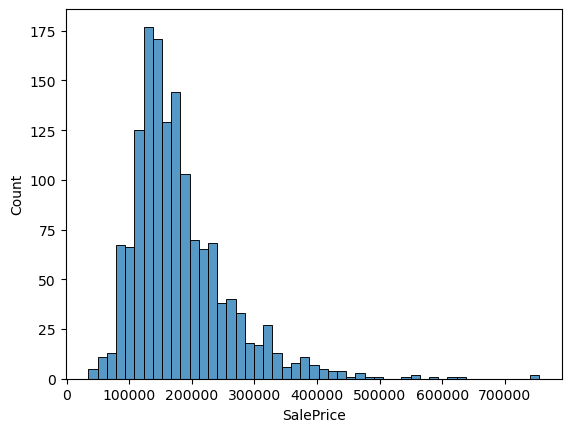

In [4]:
# histogram do zobaczenia jakie wartości mają struktury.
sns.histplot(data=train_full, x=train_full["SalePrice"])

<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

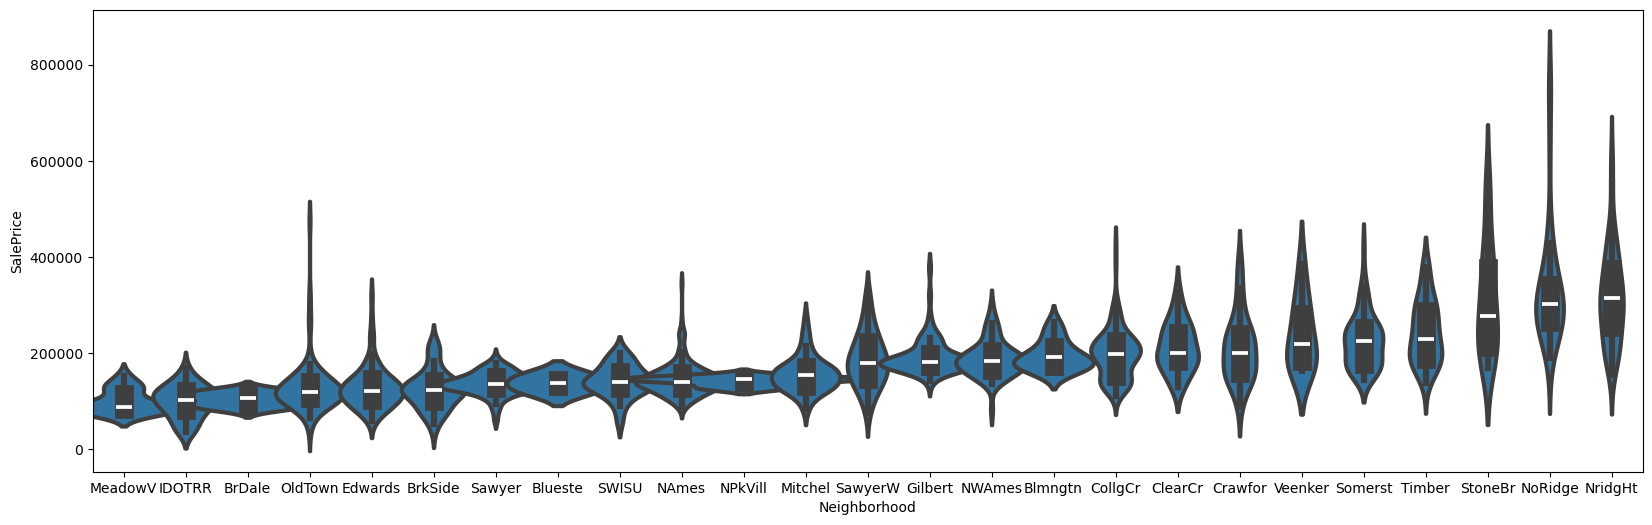

In [5]:
plt.figure(figsize=(20, 6))

# Dla lepszego porównywania sortuje podane wykresy po medianie.
# Wartość index jest nam potrzebna ponieważ dzięki niej funkcja zwruci nazwy dzielnic w odpowiedniej kolejności co umożliwi parametrowi
# order ułożenie tego w odpowiedniej kolejności. 
median_group_violin_plot = train_full.groupby(['Neighborhood'])["SalePrice"].median().sort_values().index

sns.violinplot(data=train_full, x=train_full['Neighborhood'], y=train_full["SalePrice"], linewidth=3, order=median_group_violin_plot, 
               fill=True, width=4)

## Usuwanie wartości odstających
NAjpier chciałem usunąć za pomocą quartenionów ale okazuje się że ona nie ma takiego wpływu na zmianę danych jakich potrzebuję.
Dlatego użyję też MDS bo ona opiera sięna medianie i dzięki temu powininem usówać wartości odstające lepiej, ale to się okaże jak ogarnę maskowanie wartości bo okazuje się że pandas jest sprytny ale nie przewidział tego że ktoś będzie bardzo leniwy i nie będzie mu się chciało pisać ałej długiej funkcji na grupowanie a następnie na łączenie, ale za to można filtrować i na podstawie maski True/False można odwiltrować usunięte wartości.

Usówam wartości odstające po podzieleniu na dzielnice i w danej grupie obliczam maksymalną i minimalną wartość a wartości ponad te ane usówam.
Grupuję po dzielnicach ponieważ Dane SalePrice mają największą korelacje właśnie z tymi danymi.

In [6]:
def znajdz_wartosci_w_przedziale_Quartyle(x):
    
    if x._name == 'StoneBr' or x._name == 'OldTown' or x._name == 'NoRidge' or x._name == 'NridgHt':
        
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        
        IQR = Q3 - Q1
        
        min_value = Q1 - 1.5 * IQR
        max_value = Q3 + 1.5 * IQR
    
        # Ważna uwaga słowo and jakoś nie działa tak samo jak znak &
        is_in_range = (x >= min_value) & (x <= max_value)
    else:
        is_in_range = x == x
    
    return is_in_range

In [7]:
# Podana funkcja zwróci nam maskę artości binarnych wskazujące gdzie nasz warunek został spełniony i na podstawie
# Tego będę filtrował moją grupę. Jest to możliwe dzięki funkcji groupby() która umożliwia zwrucenie w odpowiedniej kolejności całej naszej tabeli.
# Do zastosowania w ogółnej nie pogrupowanej naszej tabeli.
mask = train_full.groupby('Neighborhood')['SalePrice'].transform(znajdz_wartosci_w_przedziale_Quartyle)

# Żeby zastosować masę wystarczy wpisać w nawiasy kwadratowe naszą maskę i już
train_full = train_full[mask]
print(train_full['SalePrice'])

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1454    175000
1455    210000
1456    266500
1457    142125
1458    147500
Name: SalePrice, Length: 1445, dtype: int64


<Axes: xlabel='SalePrice', ylabel='Count'>

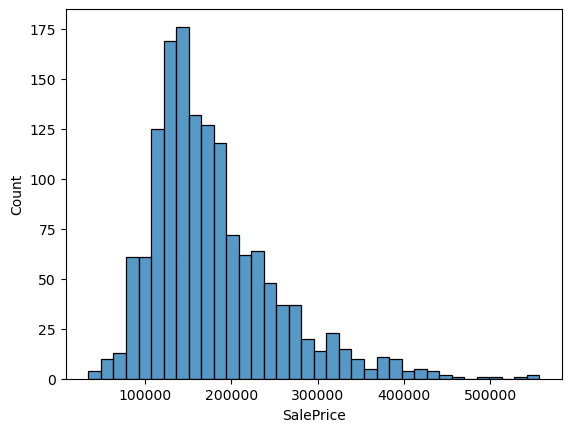

In [8]:
# histogram do zobaczenia jakie wartości mają struktury.
sns.histplot(data=train_full, x=train_full["SalePrice"])

In [9]:
# UStawienie normalizacji dla moich przewidywanych wartości.
train_full['SalePrice'] = np.log1p(train_full['SalePrice'])

test_to_analise['SalePrice'] = np.log1p(test_to_analise['SalePrice'])
# histogram do zobaczenia jakie wartości mają struktury.
sns.histplot(data=train_full, x=train_full["SalePrice"])

NameError: name 'test_to_analise' is not defined

### Podstawowe działania w statystyce
zostanie obliczona wartość maksymalna i minimalna, średnia, mediana i odchylenie standardowe dla zbioru danych z kolumny sale price, w celu zorientowania się jak bardzo dane są od siebie rozstrzelone, a Mediana będzie nam po to by zobaczyć jak duże jest odchylenie względem środka. Odchylenie standardowe będzie wskazywało faktyczne odstępstwa danych od średniej. Odchylenie standardowe zostanie wyrażone w **współczynnik zmienności** ponieważ odchylenie standardowe będzie przedstawiało dane ale w tej samej jednostce co dane na których operowaliśmy i właśnie współczynnik zmienności pozwoli nam zamienić podaną ilość na właśnie ilość danych ale wykonanych w procentach. Czyli powie nam w ilu procentach występuje odstępstwo od średniej.

In [ ]:
print(train_full["SalePrice"].median())
print(train_full["SalePrice"].mean())
mean_SalePrice = train_full["SalePrice"].mean()
std_SalePrice = train_full["SalePrice"].std()
max_SalePrice = train_full["SalePrice"].max()
min_SalePrice = train_full["SalePrice"].min()

print()
print("Odchylenie standardowe wyrażone w współczynnik zmienności.")
print((std_SalePrice/mean_SalePrice) * 100)
print("Normal STD:")
print(std_SalePrice)

# Uwaga!!! Regóła empiryczna jest w tym wypadku tylko w gwoli ciekawostki bo tak naprawdę nie mogę jej zastosować bo dane są bocno skośne.
print()
print(f"max - min: {max_SalePrice - min_SalePrice}")
print("Check empirical rule 99.7:")
print(f"{mean_SalePrice + 3 * std_SalePrice}")

In [ ]:
# Usówanie te dane które nie dacą żadnych sensownych wniosków do porównywania np. numer id.
# Reszte kolumn usunołem bo ich dane były wręcz takie same i nie dały by żadnych sensownych wniosków.

# USunięcie kolumn które nie wnoszą żadnej sensownej informacji
train_to_analise = train_full.drop(columns=['Id','Utilities','Condition2','PoolQC',
                                            'PoolArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                                            'ScreenPorch', 'MoSold', 'YrSold', 'Street', 'Condition1', 
                                            'Functional'])

test_to_analise = test.drop(columns=['Id','Utilities','Condition2','PoolQC',
                                     'PoolArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                                     'ScreenPorch', 'MoSold', 'YrSold',
                                     'Street', 'Condition1','Functional'])

In [ ]:
# Znajdywanie kolumn o typie danych tekstowym
categorical_columns = sklearn.compose.make_column_selector(dtype_include=object)
categorical_columns = categorical_columns(train_to_analise)

##  Zrobienie tabeli zrobienie tabeli przedstawiającą ilość werand jakie ma dom
Założenie polegające na tym że kupujący będzie zwracał uwagę na ilość a nie do końca na rodzaj.

In [ ]:
# Wybieram kolumny jakie chcę uwzględnić w moich obliczeniach.
kolumny_werand = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

# Stwórz nową kolumnę 'wieksze_niz_0', która zlicza wartości > 0 w każdym wierszu z wybranych kolum
train_to_analise['count_of_porch'] = (train_full[kolumny_werand] > 0).sum(axis=1)

## Dodanie tabel w stylu one hot encoding do tego by przedstawiały jakie typy werand zawiera podany dom

In [ ]:
train_to_analise['if_OpenPorchSF_current'] = np.where(train_full['OpenPorchSF'] > 0, 1, 0)
train_to_analise['if_EnclosedPorch_current'] = np.where(train_full['EnclosedPorch'] > 0, 1, 0)
train_to_analise['if_3SsnPorch_current'] = np.where(train_full['3SsnPorch'] > 0, 1, 0)
train_to_analise['if_ScreenPorch_current'] = np.where(train_full['ScreenPorch'] > 0, 1, 0)

figure, axes = plt.subplots(3, 2, figsize=(10,5))

sns.histplot(ax=axes[0,0], data=train_to_analise, x=train_to_analise["if_OpenPorchSF_current"])
sns.histplot(ax=axes[0,1], data=train_to_analise, x=train_to_analise["if_EnclosedPorch_current"])
sns.histplot(ax=axes[1,0], data=train_to_analise, x=train_to_analise["if_3SsnPorch_current"])
sns.histplot(ax=axes[1,1], data=train_to_analise, x=train_to_analise["if_ScreenPorch_current"])

# Dzięki wykonanym wykresom widać że nie ma sensu wykonywanie dodatkowych podkolumn pokazujących zawierający konkretny rodzaj werandy ponieważ 
# te dane są zbytnio rozproszone więc dlatego pozostane przy liczbie werand

train_to_analise.drop(['if_OpenPorchSF_current', 'if_EnclosedPorch_current', 'if_3SsnPorch_current', 'if_ScreenPorch_current'], 
                      axis='columns', 
                      inplace=True)

# Dodane kolumny zawierającą łączną powierzchnię wszystkich werand
train_to_analise['sum_of_area_porch'] = train_full[kolumny_werand].sum(axis=1)

sns.histplot(ax=axes[2,0], data=train_to_analise, x=train_to_analise["sum_of_area_porch"])
sns.histplot(ax=axes[2,1], data=train_to_analise, x=train_to_analise["count_of_porch"])

# Dodanie nowo utworzonych kolumn do zbioru testowego
test_to_analise['count_of_porch'] = train_to_analise['count_of_porch']
test_to_analise['sum_of_area_porch'] = train_to_analise['sum_of_area_porch']
display(test_to_analise)

## Znajdywanie kolumn w któych występuje duża liczba odchyleń
Na tej podstawie zacznę analizę ponieważ dzięki temu znajdę bardzo zniekształcane dane

In [ ]:
for column in train_to_analise:
    if (column in categorical_columns) == False:
        std = train_to_analise[column].std()
        mean = train_to_analise[column].mean()
        if(((std/mean) * 100) > 35):
            print(f"{column} ->CV ->{(std/mean) * 100}")
        

## Uzupełnianie brakujących danych w GarageYrBlt
Jest to konieczne ponieważ w tej kolumnie występuje aż 81 brakujących danych, a jak pokazuje korelogram to ta kolumna jest istotna dla podanego predykcji mojego modelu.

Uzupełnie te dane na medianą w grupie podzielonych na podstawie roku budowy domu, a skoro dom wtedy powstał to by oznaczało że garaż również w tym samym roku powstał. Ponieważ jak pokazuje korelogram to właśnie ta kolumna GarageYrBlt jest silnie połączona z YearBuilt.

In [ ]:
train_to_analise['GarageYrBlt'] = train_to_analise['GarageYrBlt'].replace("none", np.nan)

median_in_group = train_to_analise.groupby('YearBuilt')['GarageYrBlt'].transform("median")

train_to_analise['GarageYrBlt'] = train_to_analise['GarageYrBlt'].fillna(median_in_group)

# To samo dla zbioru testowego
test_to_analise['GarageYrBlt'] = test_to_analise['GarageYrBlt'].replace("none", np.nan)

median_in_group = test_to_analise.groupby('YearBuilt')['GarageYrBlt'].transform("median")

test_to_analise['GarageYrBlt'] = test_to_analise['GarageYrBlt'].fillna(median_in_group)

### Przez to że niektóre grópy miały by tylko po jedną wartość i akurat tą wartością był NaN.
Rzeby temu zaradzić to wykonam najpierw uzupełnienie tych wartości za pomocą 0, a potem do tych wartości dodam rok wymudowy przypisanych do tego wiersza z kolumny danych YearBuilt.

In [ ]:
train_to_analise['GarageYrBlt'] = train_to_analise['GarageYrBlt'].fillna(0)

train_to_analise['GarageYrBlt'] = np.where(train_to_analise['GarageYrBlt'] == 0, train_to_analise['YearBuilt'], train_to_analise['GarageYrBlt'])

# To samo dla zbioru testowego
test_to_analise['GarageYrBlt'] = test_to_analise['GarageYrBlt'].fillna(0)

test_to_analise['GarageYrBlt'] = np.where(test_to_analise['GarageYrBlt'] == 0, test_to_analise['YearBuilt'], test_to_analise['GarageYrBlt'])

## Uzupełnienie brakujących danych w MasVnrArea
Ze względu na dużą korelację a także w związku z małą liczbą danych to tą wartością też trzeba się zająć, ale przez to że ta dana ma tylko puste wartości a nie wartości NaN tak jak miało to miejsce w GarageYrBlt to zakładam że to będzie wartość 0 i każda nieznana wartość zostanie właśnie na zero zamieniona.

In [ ]:
train_to_analise['MasVnrArea'] = train_to_analise['MasVnrArea'].fillna(0)


test_to_analise['MasVnrArea'] = test_to_analise['MasVnrArea'].fillna(0)

# Uzupełnianie brakujących danych zerami W tym przypadku to jest nie szodliwe ponieważ jest tam tylko jeden
# wiersz w tych kolumnach który ma brakującą danę
test_to_analise['TotalBsmtSF'] = test_to_analise['TotalBsmtSF'].fillna(0)
test_to_analise['BsmtFinSF1'] = test_to_analise['BsmtFinSF1'].fillna(0)
test_to_analise['BsmtFinSF2'] = test_to_analise['BsmtFinSF2'].fillna(0)
test_to_analise['BsmtUnfSF'] = test_to_analise['BsmtUnfSF'].fillna(0)

## Analiza wartości odstających na wykresie box
Podany wykres umożliwia szybką wizualizację jak dużo jest wartości odstających

In [ ]:
sns.boxplot(data=train_full, x=train_full["SalePrice"], y=train_full['Neighborhood'])

In [ ]:
plt.figure(figsize=(20, 6))

# Dla lepszego porównywania sortuje podane wykresy po medianie.
# Wartość index jest nam potrzebna ponieważ dzięki niej funkcja zwruci nazwy dzielnic w odpowiedniej kolejności co umożliwi parametrowi
# order ułożenie tego w odpowiedniej kolejności. 
median_group_violin_plot = train_full.groupby(['Neighborhood'])["SalePrice"].median().sort_values().index

sns.violinplot(data=train_full, x=train_full['Neighborhood'], y=train_full["SalePrice"], linewidth=3, order=median_group_violin_plot, 
               fill=True, width=4)

### Wyszukiwanie danych o rozkładzie normalnym przez test Shapiro-Wilka

In [ ]:
Zbiór_wartości_o_rozkładzie_normalnym = []
Odrzucone_zbiory = []

print("zbiory dla shapiro-wilk")
for kolumn in train_to_analise.drop(columns=categorical_columns):
    shapiro_test = stats.shapiro(train_to_analise[kolumn], nan_policy='omit')
    if kolumn == 'count_of_porch':
        cos = 0
    if shapiro_test.pvalue > 0.05:
        Zbiór_wartości_o_rozkładzie_normalnym.append(kolumn)
    else:
        Odrzucone_zbiory.append(kolumn)

print()
print("Zbiory o rozkładzie normalnym")
print(Zbiór_wartości_o_rozkładzie_normalnym)
print()
print("Zbiory odrzucone o nie o rozkładzie normalnym")
print(Odrzucone_zbiory)

print("Zbiory dla Andersona-Darlinga")
for kolumn in train_to_analise.drop(columns=categorical_columns):
    andersonTest = stats.anderson(train_to_analise[kolumn])
    for critical in andersonTest.critical_values:
        if andersonTest.statistic < critical:
            Zbiór_wartości_o_rozkładzie_normalnym.append([critical, kolumn])
            break
        else:
            Odrzucone_zbiory.append([critical, kolumn])

print()
print("Zbiory o rozkładzie normalnym")
print(Zbiór_wartości_o_rozkładzie_normalnym)
print()
print("Zbiory odrzucone o nie o rozkładzie normalnym")
print(Odrzucone_zbiory)

### Wniosek!!!
Przedstawione wyrzej metody są zbyt czułe na wykrycie danych o rozkładzie normalnym

# Korelogramy

In [ ]:
# Wyodrębnienie danych o typie numerycznym z moich głównych danych
train_to_pearsonCorelogram = train_to_analise.drop(columns=categorical_columns)

# Obliczanie macierzy korelacji
# Metoda .corr() oblicza współczynnik korelacji Pearsona pomiędzy każdą parą kolumn w tabeli d.
# Wynikiem jest nowa tabela (DataFrame) o wymiarach np. 26x26, gdzie każda komórka (i, j) zawiera 
# informację o korelacji między kolumną i a kolumną j.
corr = train_to_pearsonCorelogram.corr()

np.ones_like(corr, dtype=bool): Tworzy macierz o takim samym kształcie jak corr, ale wypełnioną wartościami True.
np.triu(...): Funkcja triu (od triangle upper) bierze tę macierz True i zwraca jej górny trójkąt. Wartości w górnym trójkącie (wraz z przekątną) pozostają True, a reszta staje się False.

W efekcie mask to macierz wartości True/False, która posłuży do "zakrycia" górnej, zbędnej części heatmapy.

In [ ]:
from matplotlib.pyplot import figure

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# Jestem świadomy ustawiania przedziału od 3 do -3 ponieważ dzięki temu moja pula kolorów będzie lepsza do analizy a gdyby była by pula kolorów od
# 1 do -1 to kolory wydawały by się bardzo podobne i nie było by widać dokładniejszych różnic.
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})

Wniosek wyciągnięty z analizy korelogramu:
Dzięki temu wykresowi jestem w stanie stwierdzić które kolumny najbardziej odziaływują na moją cenę domu.

Jak dokonałem takiej analizy:
Podaną analize dokonałem na podstawie kolorów kolumn zawartych w wierszu dotyczącym SalePrice i te kwadraciki które mają bardzo małe powiązanie (czyli mają bardzo jasny kolor) to oznacza że są bardzo mało powiązane ze sobą.

# Łączenie za pomocą PCU

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Przyjmowanie wartości jakie mają zostać podjęte pcu
# column_PCU = train_to_analise[['LowQualFinSF','2ndFlrSF','1stFlrSF','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']]
column_PCU = train_to_analise[['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']]
column_PCU_test = test_to_analise[['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']]

scaler = StandardScaler()
column_PCU = scaler.fit_transform(column_PCU)
column_PCU_test = scaler.fit_transform(column_PCU_test)

pca = PCA(n_components=1)
column_PCU = pca.fit_transform(column_PCU)
column_PCU_test = pca.fit_transform(column_PCU_test)


# Usówanie zbędnej kolumny
# train_to_analise = train_to_analise.drop(columns=['LowQualFinSF','2ndFlrSF','1stFlrSF','TotalBsmtSF',
#                                                   'BsmtUnfSF','BsmtFinSF2','BsmtFinSF1'])
train_to_analise = train_to_analise.drop(columns=['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1'])
train_to_analise['PC_added'] = column_PCU

test_to_analise = test_to_analise.drop(columns=['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1'])
test_to_analise['PC_added'] = column_PCU_test

print(column_PCU)

In [ ]:
train_to_analise['Total_flor_SF'] = train_to_analise['1stFlrSF'] + train_to_analise['2ndFlrSF']
train_to_analise = train_to_analise.drop(columns=['1stFlrSF','2ndFlrSF'])

test_to_analise['Total_flor_SF'] = test_to_analise['1stFlrSF'] + test_to_analise['2ndFlrSF']
test_to_analise = test_to_analise.drop(columns=['1stFlrSF','2ndFlrSF'])

# Obliczanie Variance inflaction factor (VIF) dla kolumn numerycznych

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Usówanie wartości kategorycznych bo ta funkcja tego za bardzo nie udzwignie.
data_vif = train_to_analise.drop(columns=categorical_columns)

# Szybkie mapowanie funkcji. Wysyłam podaną wartość X.values zamiast zwykłego x ponieważ do funkcji muszę 
# wsyłać tylko macierz a nie dataframe z pandas. Do funkcji więc wysyłam variance_inflation_factor jedemn parametr macierzy
# a drugi index obliczanej kolumny. Dzięki wukonanemu mapowaniu mogę uzyskać szbkom tablicę ze wszystkimi obliczonymi 
# wartościami VIF dla każdej kolumny
# Tworzymy DataFrame od razu z dwiema kolumnami
data_vif = pd.DataFrame({
    "feature": data_vif.columns, # Kolumna z nazwami
    "VIF": [variance_inflation_factor(data_vif.values, i) for i in range(len(data_vif.columns))] # Kolumna tylko z obliczonymi wartościami
})

display(data_vif)

# Wnioski
Niektóre kolumny mają wartość inf co przyjmóję za perfekcyjne ich dopasowanie.

## Podjęte działanie
Stworzę osobną kolumnę na całkowitą ilość stóp w pierwszym i w 2 pietrze. Efektem jest zonwu nadmierne dopasowanie więc usunę te kolumny.

2 Podjęte działaniec -> Będzie to próba połączenia danych za pomocą Principal Component Analysis.

# Condintion number

In [ ]:
# Usówanie wartości kategorycznych bo ta funkcja tego za bardzo nie udzwignie.
cond_no = train_to_analise.drop(columns=categorical_columns)

# Normalizowanie karzdej kolumny bo wartość condition jest obliczana na odległościach między punktami więc musi być 
# ona zrobiona tak by wartości miały tę samom miarę do porównania a nie żeby jedna bardzo duża wartość zniekształcała wynik.
cond_no.transform(np.log1p)
cond_no = np.linalg.cond(cond_no.values)

print(f"Condition Number wynosi: {cond_no}")

# Scatter plots
Podane narysowane wykresy punktowe będą niezbędnie ponieważ muszę sprawdzić jaki rozkład mają moje wartości i któremu konkretnie rozkładowi mogę je przypisać

# Obliczanie współczynnika eth by poznać korelację między wartościami kategorycznymi i numerycznymi

In [ ]:
from dython.nominal import associations

# Dodawanie wartości cen sprzedarzy domów
categorical_columns.append('SalePrice')
associations(train_to_analise[categorical_columns], nom_num_assoc ='correlation_ratio', figsize=(20, 20))

Dzięki podanemu korelogramowi jestem w stanie ocenić jak duży wpływ mają wartości kategoryczne na SalePrice. Zbadałem bardzo niskie wartości i okazało się że karzde zmienne kategoryczne miały tendencje do skrajności (wyrużniania tylko jednej bardzo powszechnej kategorii), co oczywiście dawało bardzo znikome dane do analizowania.

# Sprawdzanie czy te same dane kategoryczne są zawarte w kolumnach
Sprawdzenie to musi wystąpić ponieważ musimy być pewny że nasz model jest trenowany na tych samych danych na których będzie sprawdzany. Przykład: Zosia uczy się rozpoznawać gatunki jabłek, a jej koleżanka daje jej gruszkę.

Funkcja sprawdzająca czy w dwuch zbiorach są te same kategorie tekstowe.

In [ ]:
def If_the_same_categorical_in_both_dataframe(list_1, list_2, categorical_columns):
    for categorical_column in categorical_columns:
        if set(list_1[categorical_column]) == set(list_2[categorical_column]):
            continue
        else:
            return set(list_1[categorical_column]) - set(list_2[categorical_column])

    return 0

# Uwaga!!!
bardzo poważny problem z żadkimi danymi kategorycznymi w zbiorze walidacyjnym lub testowym
problematyczne kodowanie ponieważ okazuje się że target encoding nie radzi sobie z danymi które występują żadko

## Zamiana wartości NA na None by program nie brał tych wartości że to jest brak danych a nie wartość kategoryczna
Problem jest bo program konwertował wartość NA na typ sugerujący brak danych a nie że to jest osobny typ danych. Co będzie powodowało błędy w rozumieniu programu.

In [ ]:
train_to_analise_to_check_place_of_NaN = train_to_analise.drop(columns=categorical_columns)
display(train_to_analise_to_check_place_of_NaN.isna().sum())

In [ ]:
train_to_analise.fillna('Noune', inplace=True)
test_to_analise.fillna('Noune', inplace=True)

print(train_to_analise.shape)
print(test_to_analise.shape)

In [ ]:
train_to_analise.to_csv("./Przetworzone dane/Normalne_dane_treningowe.csv")
test_to_analise.to_csv(r"./Przetworzone dane/Test_ZimputowaneDane_MetodaLGB_zakodowaneWartościTekstowe.csv")